# Gender Pay Gap. A sad and true story.

## Overview
The 2018 Kaggle Survey is a highly interesting dataset comprised of questions around many topics (e.g. tools used for Machine Learning and data analysis, industry, geography). This analysis attempts to outline patterns around gender pay gap. Not surprisingly, a considerable income discrepancy is found between genders, impacting women negatively. The analysis then moves towards questioning whether this difference in income is justified, which proves that it isn't. Women generally get a worse deal irrespective of experience and education level.

## Data Preparation
For this analysis, some of the data points have been manipulated respective to the original dataset. These are:
- **Gender**: only the samples where the person who filled the survey declared being either a man or a woman have been kept.
- **Range data**: answers on dimensions such as income, age or experience (e.g. in current role, coding) come mostly in two flavours: 1) as ranges (e.g. 30-34 years), in these cases an average was made between the two (e.g. 32 years); and 2) as a number with a "+" sign meaning *more than* (e.g. $500,000+), in these cases just the number was kept (e.g. 500,000).
- When considered appropriate, data has been deliberately left out in certain visualizations with the aim of better represent the reality. For instance, when showing *average income by age*, only data points that represented 50 or more respondents were included.

In [1]:
# data preparation

import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import FormatStrFormatter
from textwrap import wrap

multiple_choice = pd.read_csv('./data/multipleChoiceResponses.csv', low_memory=False)

def convert_salary(salary):

    if salary == '500,000+':
        return 500000
    else:
        try:
            a, b = salary.replace(',','').split('-')
            avg = (int(a)*1000+int(b))/2
            return avg
        except:
            return None

def convert_xp(xp, return_type):
    if xp == '30 +':
        xp = 30
    elif xp == '40+ years':
        xp = 40
    elif xp == '< 1 year':
        xp = 0.5
    else:
        try:
            a, b = xp.replace(' years', '').split('-')
            xp = (int(a)+int(b))/2
        except:
            return None
        
    if return_type == 'years':
        return xp
    elif return_type == 'seniority level':
        if xp < 3:
            return 0
        elif xp < 6:
            return 1
        else:
            return 2
    else:
        return None   

def convert_age(age):
    if age == '80+':
        return 80
    else:
        try:
            a, b = age.split('-')
            return (int(a)+int(b))/2
        except:
            return None

def convert_ind_projects(response):

    if response == 'Independent projects are much less important than academic achievements':
        return 0
    elif response == 'Independent projects are slightly less important than academic achievements':
        return 1
    elif response == 'Independent projects are equally important as academic achievements':
        return 2
    elif response == 'Independent projects are slightly more important than academic achievements':
        return 3
    elif response == 'Independent projects are much more important than academic achievements':
        return 4
    else:
        return None

def importance_scale(response):

    if response == 'Not at all important':
        return 0
    elif response == 'Slightly important':
        return 1
    elif response == 'Very important':
        return 2
    else:
        return None
    
def convert_education(education, return_ints=False):
    
    education = str(education)
    
    if education.startswith('Doct'):
        if return_ints:
            return 4
        else:
            return 'Doctor'
    elif education.startswith('Mast'):
        if return_ints:
            return 3
        else:
            return 'Master'
    elif education.startswith('Prof'):
        if return_ints:
            return 2
        else:
            return 'Professional'
    elif education.startswith('Bach'):
        if return_ints:
            return 1
        else:
            return 'Bachelor'
    elif education.startswith('Some coll'):
        if return_ints:
            return 0
        else:
            return 'Non-finished University'
    else:
        return None

df = pd.DataFrame()
df['gender'] = multiple_choice.Q1[1:]
df['current_role_xp'] = multiple_choice.Q8[1:].apply(convert_xp, args = ('years',))
df['coding_xp'] = multiple_choice.Q24[1:].apply(convert_xp, args = ('years',))
df['ml_xp'] = multiple_choice.Q25[1:].apply(convert_xp, args = ('years',))
df['current_role_xp_level'] = multiple_choice.Q8[1:].apply(convert_xp, args = ('seniority level',))
df['coding_xp_level'] = multiple_choice.Q24[1:].apply(convert_xp, args = ('seniority level',))
df['ml_xp_level'] = multiple_choice.Q25[1:].apply(convert_xp, args = ('seniority level',))
df['income'] = multiple_choice.Q9[1:].apply(convert_salary)
df['geography'] = multiple_choice.Q3[1:]
df['original_age'] = multiple_choice.Q2[1:]
df['age'] = multiple_choice.Q2[1:].apply(convert_age)
df['ind_projects_importance'] = multiple_choice.Q40[1:].apply(convert_ind_projects)
df['ml_fairness'] = multiple_choice.Q41_Part_1[1:].apply(importance_scale)
df['ml_explainability'] = multiple_choice.Q41_Part_2[1:].apply(importance_scale)
df['ml_reproducibility'] = multiple_choice.Q41_Part_3[1:].apply(importance_scale)
df['title'] = multiple_choice.Q6[1:]
df['industry'] = multiple_choice.Q7[1:]
df['education'] = multiple_choice.Q4[1:].apply(convert_education)
df['education_level'] = multiple_choice.Q4[1:].apply(convert_education, return_ints=True)

df = df[df.gender.isin(['Male', 'Female'])]

fig_height = [8]
fig_width = [16]
title_fontsize = [20]
axis_labels_fontsize = [20]
tick_fontsize = [15]
legend_fontsize = [15]

Income gap between men and women is mostly negligible for respondents throughout their 20s. After then though, a clear pay gap can be observed. 

A painful datapoint is that **women on their late 40s are at the same pay grade as men on their early 30s**, more specifically  around $\$$64k.

Another pattern to look at is the **pay boost men obtain after their 40 year-old-mark**. In average, men pass from $\$$79k on their early 40s to $\$$94k before they are 50, which represents an increase of 23%.

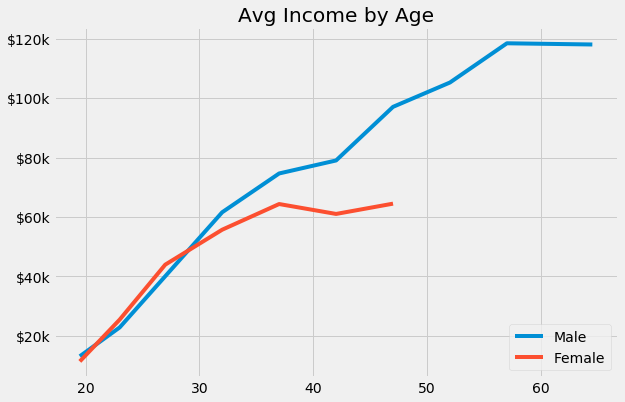

In [2]:
plt.style.use('fivethirtyeight')

df_plot = sqldf("""
with bd as (
    select gender as Gender, age, avg(income)*1.0/1000 as income_mean, sum(case when income is not null then 1 else 0 end) as income_count
    from df
    group by 1, 2
)
, fl as (
    select *
    from bd
    where Gender = 'Female'
    and income_count >= 50
)
, ml as (
    select *
    from bd
    where Gender = 'Male'
    and income_count >= 50
)
, ages as (
    select distinct fl.age
    from fl
    join ml on fl.age = ml.age
)
select *
from fl
--where age in (select * from ages)
UNION ALL
select *
from ml
--where age in (select * from ages)
""")

df_plot.sort_values(by='age', inplace=True)


fig, ax = plt.subplots(figsize=(9,6))

ax.plot('age', 'income_mean', data=df_plot[df_plot['Gender']=='Male'])
ax.plot('age', 'income_mean', data=df_plot[df_plot['Gender']=='Female'])
ax.legend(['Male', 'Female'], loc=4)
ax.set_title('Avg Income by Age')
ax.yaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))

plt.show()

This last point, the **considerable high salary men obtain after their late 40s**, sparks two questions.

First, what roles allow men to enjoy this pay grade? **Mostly management positions** such as Chief Officer ($\$$173k) or Manager ($\$$127k), **and senior development positions** such as Data Scientist ($\$$110k) or Software Engineer ($\$$108k).

And second, do women have access to these positions? Not really. While diversity among data scientists is well balanced, **there can be found only one woman for every 4 male chief officers, 3 managers or almost 2 software engineers**.

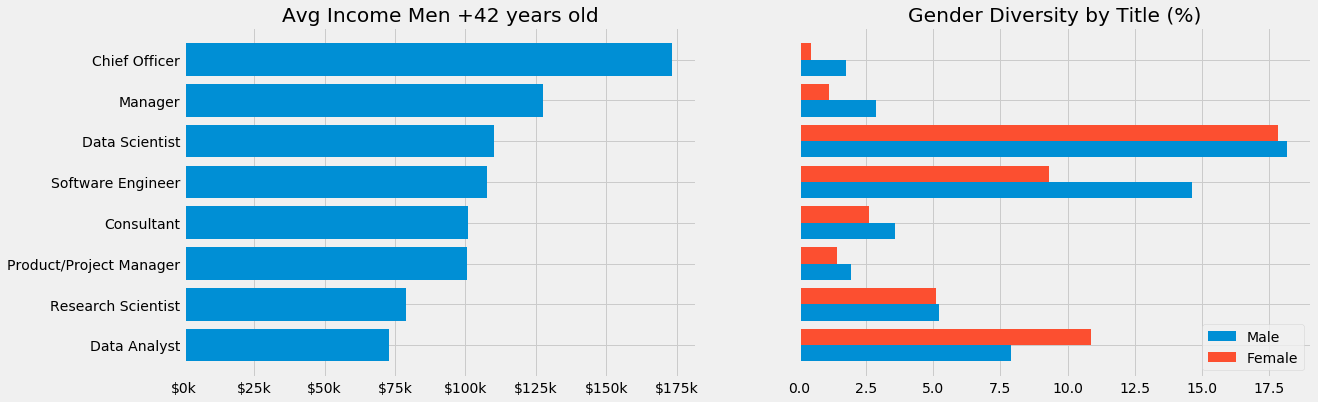

In [46]:
df_plot = sqldf("""
select title, gender, avg(income)*1.0/1000 as income_mean, count(*)
from df
where age > 42 and gender = 'Male' and title is not null and income is not null and title != 'Other'
group by 1, 2
having count(*) >= 50
order by avg(income) desc
limit 10
""")


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6), sharey=True)

df_plot.sort_values(by='income_mean', ascending=True, inplace=True)

yticks = np.arange(len(df_plot.title))
yticklabels = list(df_plot.title)

ax1.barh(yticks, 'income_mean', data=df_plot)
ax1.set_title('Avg Income Men +42 years old', )
ax1.xaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticklabels)

df_plot = sqldf("""
with high_paying_titles as (
    select title, gender, avg(income)*1.0/1000 as income_mean, count(*)
    from df
    where age > 42 and gender = 'Male' and title is not null and income is not null and title != 'Other'
    group by 1, 2
    having count(*) >= 50
    order by avg(income) desc
    limit 10
)
, total_counts as (
    select gender, count(*) as gender_count
    from df
    where title is not null
    group by 1
)
select df.title, df.gender, tc.gender_count, count(*), 100*count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Female' and df.title in (select title from high_paying_titles)
group by 1, 2, 3
UNION ALL
select df.title, df.gender, tc.gender_count, count(*), 100*count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Male' and df.title in (select title from high_paying_titles)
group by 1, 2, 3
""")


df_plot = df_plot.pivot(index='title', columns='gender', values='gender_perc')


df_plot = df_plot.reindex(yticklabels)

ax2.barh(yticks-0.2, df_plot.Male, 0.4, label='Male')
ax2.barh(yticks+0.2, df_plot.Female, 0.4, label='Female')
ax2.legend(['Male', 'Female'], loc=4)
ax2.set_title('Gender Diversity by Title (%)')

plt.show()

Country-wise, the data shows some very interesting patterns too. **Regardless of gender**, when it comes to income, **the best countries to work at are identical**, having the US as the leader followed by Canada, UK and Germany. As a man, one can make almost 4 times more in the US than in India, while women can make well more than 5 times more in the US than in China.

However, in absolute terms, it is in the best country to work at income-wise, **the US**, the one that **shows the biggest gap between men and women** ($\$$25k), having France and the UK following close behind ($\$$19k and $\$$17k, respectively).

Surpsingly, India is the only country where men make (slightly) less than women ($\$$2.7k).

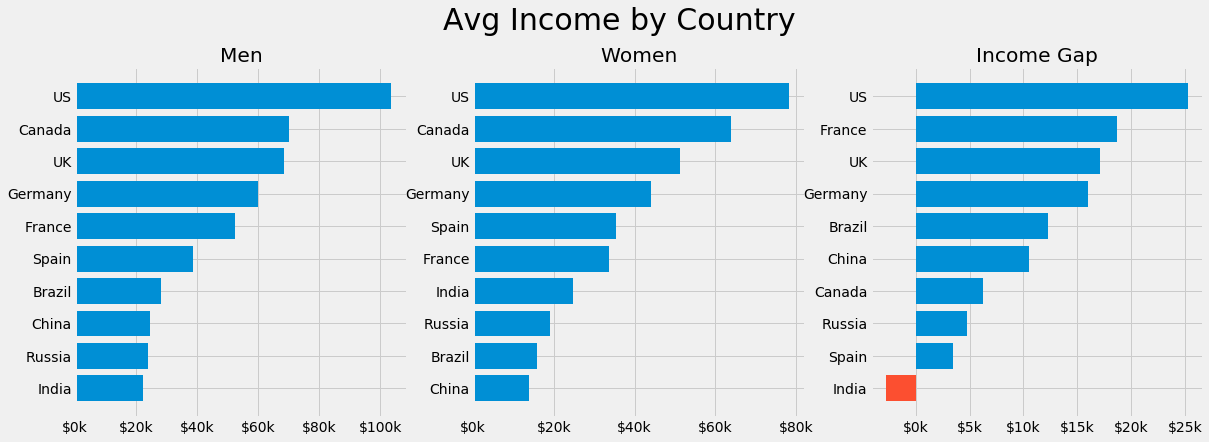

In [47]:
df_plot = sqldf("""
with bd as (
    select gender, geography, avg(income)*1.0/1000 as income_mean, sum(case when income is not null then 1 else 0 end) as income_count
    from df
    where geography != 'Other'
    group by 1, 2
)
, fl as (
    select *
    from bd
    where gender = 'Female'
    and income_count >= 50
)
, ml as (
    select *
    from bd
    where gender = 'Male'
    and income_count >= 50
)
, geos as (
    select distinct fl.geography
    from fl
    join ml on fl.geography = ml.geography
)
select case when lower(fl.geography) like '%united%states%' then 'US'  
            when lower(fl.geography) like '%united%kingdom%' then 'UK' else fl.geography end as geography
    , fl.income_mean as fl_income
    , ml.income_mean as ml_income
    , (ml.income_mean-fl.income_mean) as income_gap
    , case when (ml.income_mean-fl.income_mean) > 0 then 'positive' else 'negative' end as gap_direction
from fl
join ml on fl.geography = ml.geography
where fl.geography in (select * from geos)
order by (ml.income_mean-fl.income_mean) desc
"""
)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
fig.suptitle('Avg Income by Country', fontsize=30, y=1.02)

dfp = df_plot.sort_values(by='ml_income')
yticks = np.arange(len(dfp.geography))
yticklabels = list(dfp.geography)
yticklabels = ['\n'.join(wrap(l, 30)) for l in yticklabels]

ax1.barh(yticks, 'ml_income', data=dfp)
ax1.set_title('Men')
ax1.xaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticklabels)




dfp = df_plot.sort_values(by='fl_income')
yticks = np.arange(len(dfp.geography))
yticklabels = list(dfp.geography)
yticklabels = ['\n'.join(wrap(l, 30)) for l in yticklabels]

ax2.barh(yticks, 'fl_income', data=dfp)
ax2.set_title('Women')
ax2.xaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))
ax2.set_yticks(yticks)
ax2.set_yticklabels(yticklabels)



df_plot = sqldf("""
select geography
    , income_gap
    , case when income_gap > 0 then income_gap else 0 end as ig_pos
    , case when income_gap < 0 then income_gap else 0 end as ig_neg
from df_plot
""")

dfp = df_plot.sort_values(by='income_gap')
yticks = np.arange(len(dfp.geography))
yticklabels = list(dfp.geography)

ax3.barh(yticks, 'ig_pos', data=dfp)
ax3.barh(yticks, 'ig_neg', data=dfp)

ax3.set_title('Income Gap')
ax3.xaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))
ax3.set_yticks(yticks)
ax3.set_yticklabels(yticklabels)

plt.show()

After all this analysis a pay gap between men and women is demonstrated, but the question remains. Is that gap fair? Do men just make more money because they are more prepared? The answer is *no*.

Let's look at income based on experience on the role, coding or ML Experience.

First, women generally do not obtain any noticeable increase on their pay grade after year 7 on their current role; while **men’s pay grade is always awarded with an increase almost perfectly correlated with their years of service in the same role**.

Second, while women that show coding experience still get a worse deal, their income starts to be better correlated to men's pay-experience variables.

And third, when comparing men and women with ML experience, there is almost no different in average pay. **Maybe the scarcity of talent in this area makes an exception to what seems to be the rule in the workforce in any other dimension.**

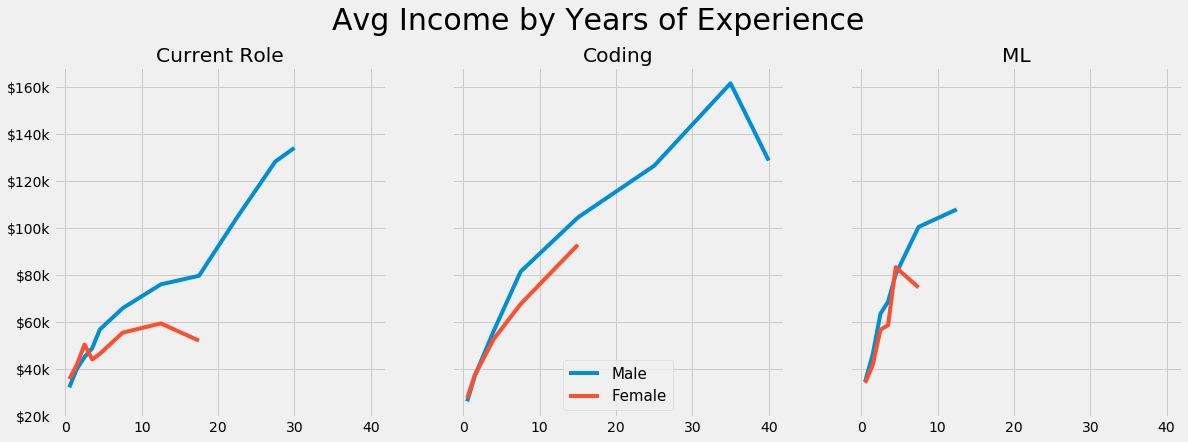

In [5]:
df_plot = sqldf("""
select gender, current_role_xp as experience, 'current_role_xp' as dimension, avg(income)*1.0/1000 as income_mean,  count(*) as population
from df
where current_role_xp is not null
group by 1, 2, 3
UNION ALL
select gender, coding_xp as experience, 'coding_xp' as dimension, avg(income)*1.0/1000 as income_mean,  count(*) as population
from df
where coding_xp is not null
group by 1, 2, 3
UNION ALL
select gender, ml_xp as experience, 'ml_xp' as dimension, avg(income)*1.0/1000 as income_mean,  count(*) as population
from df
where ml_xp is not null
group by 1, 2, 3
""")

df_plot = df_plot[df_plot['population']>=50]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6), sharey=True, sharex=True)
fig.suptitle('Avg Income by Years of Experience', fontsize=30, y=1.02)

ax1.plot('experience', 'income_mean', data=df_plot[(df_plot.gender=='Male') & (df_plot.dimension=='current_role_xp')])
ax1.plot('experience', 'income_mean', data=df_plot[(df_plot.gender=='Female') & (df_plot.dimension=='current_role_xp')])
ax1.set_title('Current Role')
ax1.yaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))

ax2.plot('experience', 'income_mean', data=df_plot[(df_plot.gender=='Male') & (df_plot.dimension=='coding_xp')])
ax2.plot('experience', 'income_mean', data=df_plot[(df_plot.gender=='Female') & (df_plot.dimension=='coding_xp')])
ax2.legend(['Male', 'Female'], loc='lower center', prop={'size': 15})
ax2.set_title('Coding')

ax3.plot('experience', 'income_mean', data=df_plot[(df_plot.gender=='Male') & (df_plot.dimension=='ml_xp')])
ax3.plot('experience', 'income_mean', data=df_plot[(df_plot.gender=='Female') & (df_plot.dimension=='ml_xp')])
ax3.set_title('ML')

plt.show()

From an education point of view, women are also paid unfairly compared to men. **Women always get an average income that is considerable lower than that of men with the same level of education**. For instance, a man that achieved a PHD will get in average $\$$14k more than his women peers. 

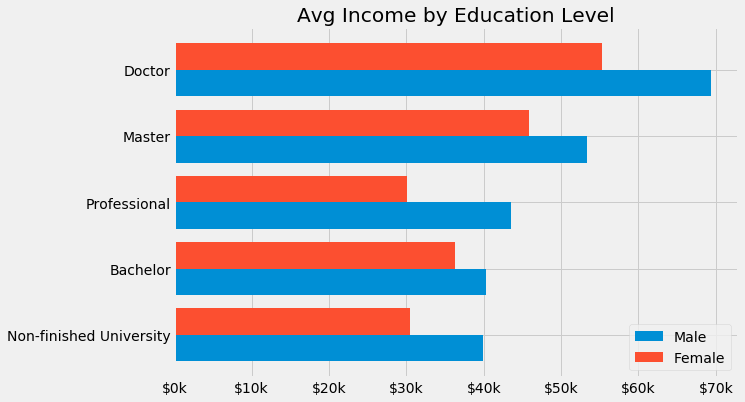

In [13]:
df_plot = sqldf("""
select gender, education, count(*) as population, avg(income)*1.0/1000 as income_mean
from df
where education is not null
group by 1, 2
having count(*)>=50
""")

df_plot = df_plot.pivot(index='education', columns='gender', values='income_mean')

education_level_order = ['Non-finished University', 'Bachelor', 'Professional', 'Master', 'Doctor']
df_plot = df_plot.reindex(education_level_order)

yticks = np.arange(len(df_plot.index))
yticklabels = list(df_plot.index)

fig, ax = plt.subplots(figsize=(9, 6))

yticks = np.arange(len(df_plot.index))
yticklabels = list(df_plot.index)

ax.barh(yticks-0.2, 'Male', data=df_plot, height=0.4, label='Male')
ax.barh(yticks+0.2, 'Female', data=df_plot, height=0.4, label='Female')
ax.set_title('Avg Income by Education Level')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

plt.show()

But let's also bring in the role dimension. Here we can see that **the only exception where women get a far better deal is for data scientists with a bachelor** (+$\$$13k). However, more educated data scientists start to be biased towards men (between $\$$3.5 to $\$$5.2 gap). And **software engineer, for instance, irrespective of education level, always get paid better** ($\$$4.7 and $\$$5.6).

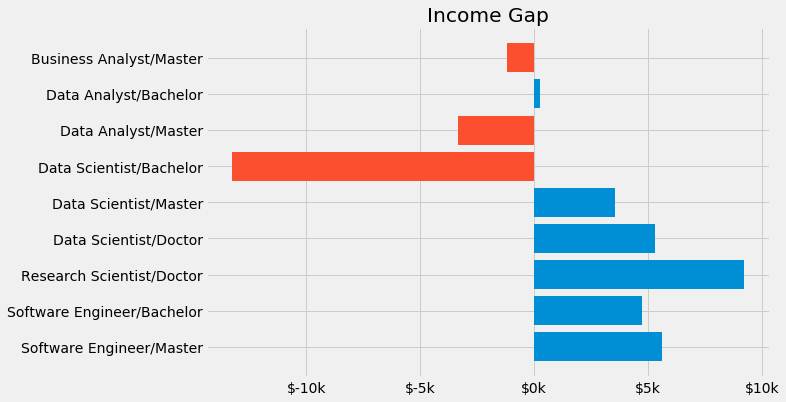

In [51]:
df_plot = sqldf("""
with bd as (
    select gender, title, education_level, education, avg(income)*1.0/1000 as income_mean, count(*) as population
    from df
    where title is not null
    and education is not null
    and title not in ('Other', 'Student')
    and income is not null
    group by 1, 2, 3, 4
    having count(*) >= 50
)
, calcs as (
    select title || '/' || education as profile
        , title
        , education
        , education_level
        , sum(case when gender='Male' then population else null end) as male_population
        , sum(case when gender='Female' then population else null end) as female_population
        , sum(case when gender='Male' then income_mean else null end) as male_income
        , sum(case when gender='Female' then income_mean else null end) as female_income
        , sum(case when gender='Male' then income_mean else null end)-sum(case when gender='Female' then income_mean else null end) as gap_income
    from bd
    group by 1, 2, 3, 4
    having abs(sum(case when gender='Male' then income_mean else null end)-sum(case when gender='Female' then income_mean else null end)) > 0
)
select calcs.*
    , case when gap_income > 0 then gap_income else 0 end as gp_pos
    , case when gap_income < 0 then gap_income else 0 end as gp_neg
from calcs
order by title desc, education_level desc
""")

fig, ax = plt.subplots(figsize=(9, 6))

yticks = np.arange(len(df_plot.profile))
yticklabels = list(df_plot.profile)

ax.barh(yticks, 'gp_pos', data=df_plot)
ax.barh(yticks, 'gp_neg', data=df_plot)
ax.set_title('Income Gap')
ax.xaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

plt.show()